<a href="https://colab.research.google.com/github/xBernardoVG/stablediffusion/blob/main/test_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Looking inside the stable diffusion Pipeline

In [ ]:
!pip install huggingface_hub
!pip install -Uq diffusers transformers fastcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 895.8/895.8 kB 13.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 85.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.9 MB/s eta 0:00:00


In [ ]:
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from diffusers import StableDiffusionPipeline
from fastcore.all import concat
from huggingface_hub import notebook_login
from PIL import Image

logging.disable(logging.WARNING)

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
#CLIP is a multi-modal vision and language model -> used for image-text similarity
#CLIP  model -> Inputs: Text| Outputs: Embeddings | Process: NN trained to decrease loss (Dot product) between the text and the correspondent image
from transformers import CLIPTextModel, CLIPTokenizer


In [ ]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

In [ ]:
# Autoencoder -> Compression algorithm based on convnets; Encoder generates Latents (compressed image) and Decoder for decompression
# UNet2D -> Input: Somewhat noisy picture | Output: Noise
from diffusers import AutoencoderKL, UNet2DConditionModel


In [ ]:
# Here we use a different VAE to the original release, which has been fine-tuned for more steps
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

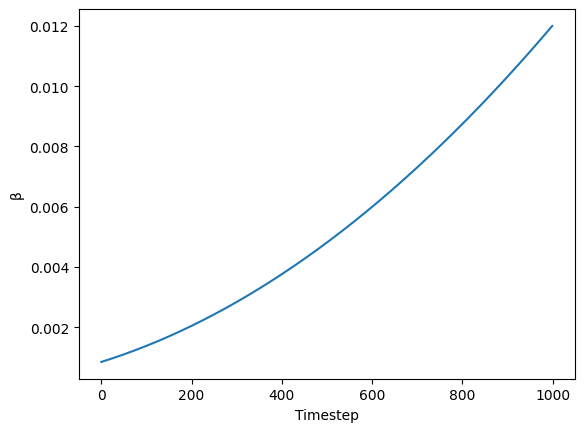

In [ ]:
# Amount of noise added to the figure -> In inference we run from lots of noise to less noise
beta_start,beta_end = 0.00085,0.012
plt.plot(torch.linspace(beta_start**0.5, beta_end**0.5, 1000) ** 2)
plt.xlabel('Timestep')
plt.ylabel('β');

In [ ]:
from diffusers import LMSDiscreteScheduler

In [ ]:
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=1000)


In [ ]:
prompt = ["a photograph of an astronaut riding a horse"]

height = 512
width = 512
num_inference_steps = 70
guidance_scale = 7.5
batch_size = 1

In [ ]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_input['input_ids']

tensor([[49406,   320,  8853,   539,   550, 18376,  6765,   320,  4558, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]])

In [ ]:
tokenizer.decode(49407)

'<|endoftext|>'

The text encoder gives us the embeddings for the text prompt we used.

In [ ]:
text_embeddings = text_encoder(text_input.input_ids.to("cuda"))[0].half()
text_embeddings.shape

torch.Size([1, 77, 768])

We also get the embeddings required to perform unconditional generation, which is achieved with an empty string: the model is free to go in whichever direction it wants as long as it results in a reasonably-looking image. These embeddings will be applied to apply classifier-free guidance.

In [ ]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
uncond_embeddings = text_encoder(uncond_input.input_ids.to("cuda"))[0].half()
uncond_embeddings.shape

torch.Size([1, 77, 768])

For classifier-free guidance, we need to do two forward passes. One with the conditioned input (text_embeddings), and another with the unconditional embeddings (uncond_embeddings). In practice, we can concatenate both into a single batch to avoid doing two forward passes.

In [ ]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

To start the denoising process, we start from pure Gaussian (normal) noise. These are our initial latents

In [ ]:
torch.manual_seed(100)
latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8))
latents = latents.to("cuda").half()
latents.shape

<ipython-input-18-1f3f382f148b>:2: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8))


torch.Size([1, 4, 64, 64])

4×64×64 is the input shape. The decoder will later transform this latent representation into a 3×512×512 image after the denoising process is complete.

Next, we initialize the scheduler with our chosen num_inference_steps. This will prepare the internal state to be used during denoising.

In [ ]:
scheduler.set_timesteps(num_inference_steps)

We scale the initial noise by the standard deviation required by the scheduler. This value will depend on the particular scheduler we use.
The scaling is important to make sure that we active all NN nodes, and ther eis no dead neurons and ensure variance

In [ ]:
latents = latents * scheduler.init_noise_sigma

We are ready to write the denoising loop. The timesteps go from 999 to 0 (1000 steps that were used during training) following a particular schedule.

In [ ]:
scheduler.timesteps

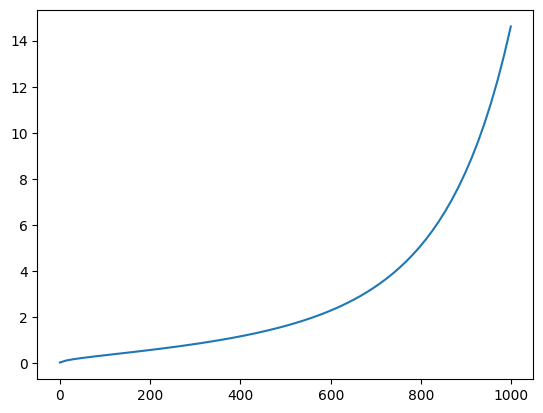

In [ ]:
plt.plot(scheduler.timesteps, scheduler.sigmas[:-1]);

In [ ]:
from tqdm.auto import tqdm

In [ ]:
for i, t in enumerate(tqdm(scheduler.timesteps)):
    input = torch.cat([latents] * 2)
    input = scheduler.scale_model_input(input, t)

    # predict the noise residual
    with torch.no_grad(): pred = unet(input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    pred_uncond, pred_text = pred.chunk(2)
    pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

    # compute the "previous" noisy sample
    latents = scheduler.step(pred, t, latents).prev_sample

  0%|          | 0/70 [00:00<?, ?it/s]

After this process complets our latents contain the denoised representation of the image. We use the vae decoder to convert it back to pixel space.

In [ ]:
with torch.no_grad(): image = vae.decode(1 / 0.18215 * latents).sample

And finally, let's convert the image to PIL so we can display it.

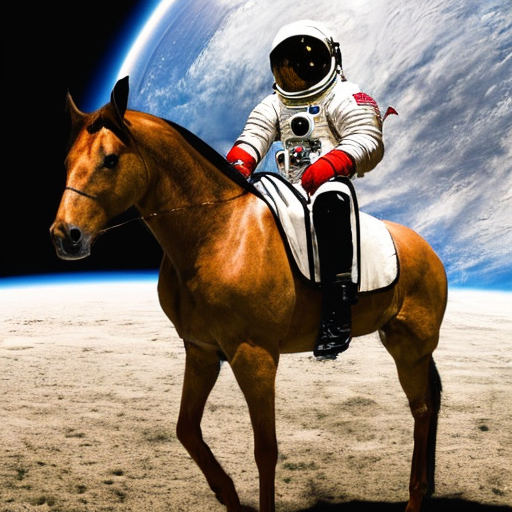

In [ ]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image[0].detach().cpu().permute(1, 2, 0).numpy()
image = (image * 255).round().astype("uint8")
Image.fromarray(image)

In [ ]:
def text_enc(prompts, maxlen=None):
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

def mk_img(t):
    image = (t/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
    return Image.fromarray((image*255).round().astype("uint8"))

In [ ]:
def mk_samples(prompts, g=7.5, seed=100, steps=70):
    bs = len(prompts)
    text = text_enc(prompts)
    uncond = text_enc([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])
    if seed: torch.manual_seed(seed)

    latents = torch.randn((bs, unet.in_channels, height//8, width//8))
    scheduler.set_timesteps(steps)
    latents = latents.to("cuda").half() * scheduler.init_noise_sigma

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
        pred = u + g*(t-u)
        latents = scheduler.step(pred, ts, latents).prev_sample

    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample

In [ ]:
height = 512
width = 512
num_inference_steps = 70
guidance_scale = 7.5
batch_size = 1

In [ ]:
prompts = [
    'a photograph of an astronaut riding a horse',
    'an oil painting of an astronaut riding a horse in the style of grant wood'
]

In [ ]:
images = mk_samples(prompts)

<ipython-input-12-63505bebb644>:8: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, height//8, width//8))


NameError: ignored